# Обучение трансформера на задачу перевода текста
**Цель**: перевод текстов с немецкого на английский

**Реализация**: будем использовать трансформер, описанный в transformer.py. Обучим его, используя техники warmup и EMA

**Оценка качества**: в качестве метрики используем bleu и accuracy

**Полученный результат**: bleu около 0.65, accuracy > 0.65

## Загрузка библиотек, данных и моделей

In [ ]:
# стандартные библиотеки
from tqdm.auto import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
# самописные
from transformer import Transformer
from ema import ExponentialMovingAverage
from warmup_cosine import WarmupCosineScheduler
# библиотеки huggingface
from datasets import load_dataset
from transformers import AutoTokenizer
import evaluate

# глобальные переменные
SRC_NAME = 'de'  # исходный язык
TRG_NAME = 'en'  # целевой язык
MAX_LENGTH = 32  # максимальная длина текстов, подаваемая модели
PATH_TO_MODEL = 'models/transformer.pt'  # файл с весами обученной модели
PATH_TO_SOLUTION = 'data/multi30k_solution.tsv'  # файл со сгенерированными текстами на английском
PATH_TO_TRAIN = 'data/multi30k_train.csv'  # файл с тренировочной выборкой
PATH_TO_TEST = 'data/multi30k_test.csv'  # файл с тестовой выборкой
PATH_TO_GRADER = 'data/multi30k_grader.csv'  # файл с текстами на немецком, которые требуется перевести
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# загрузка датасетов
data_files = {'train': PATH_TO_TRAIN, 'test': PATH_TO_TEST}
dataset = load_dataset('csv', data_files=data_files)
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

In [ ]:
# создание лоадеров
train_loader = DataLoader(dataset['train'], shuffle=True, batch_size=32)
test_loader = DataLoader(dataset['test'], shuffle=False, batch_size=32)

# загрузка токенизаторов
tokenizers = {
    TRG_NAME: AutoTokenizer.from_pretrained('bert-base-uncased'),
    SRC_NAME: AutoTokenizer.from_pretrained('dbmdz/bert-base-german-uncased')
}

# подгружаем метрику
bleu_score = evaluate.load('bleu')

## Анализ текстов и характеристик обучения

**Нарисуем на графике как у нас будет меняться шаг при использовании warmup**

Text(0, 0.5, 'Learning rate')

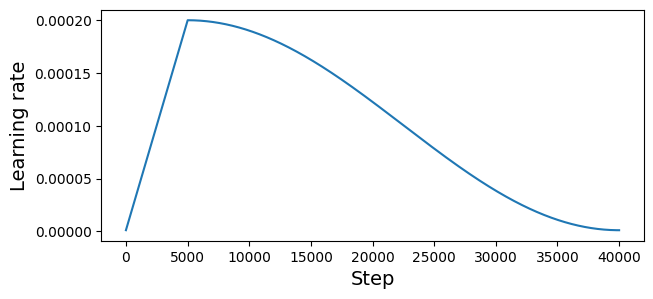

In [ ]:
dummy_model = nn.Linear(1, 1)
optimizer = torch.optim.Adam(dummy_model.parameters(), lr=2e-4)
scheduler = WarmupCosineScheduler(optimizer, warmup_steps=5000, max_training_steps=40000, min_lr=1e-6)

lrs = []
for i in range(40000):
    optimizer.step()
    scheduler.step()
    lrs.append(scheduler.get_lr())

plt.figure(figsize=(7, 3))
plt.plot(lrs)
plt.xlabel('Step', size=14)
plt.ylabel('Learning rate', size=14)

**Посмотрим на длины текстов**

  0%|          | 0/29000 [00:00<?, ?it/s]

  0%|          | 0/29000 [00:00<?, ?it/s]

(array([2.000e+00, 2.000e+00, 4.600e+01, 1.940e+02, 5.020e+02, 9.470e+02,
        1.440e+03, 4.047e+03, 2.431e+03, 2.539e+03, 2.271e+03, 2.279e+03,
        1.963e+03, 1.772e+03, 2.889e+03, 1.149e+03, 8.720e+02, 7.160e+02,
        5.940e+02, 4.910e+02, 4.060e+02, 5.590e+02, 2.050e+02, 1.460e+02,
        1.290e+02, 9.900e+01, 6.800e+01, 5.600e+01, 6.200e+01, 2.200e+01,
        2.500e+01, 1.900e+01, 1.300e+01, 1.000e+01, 7.000e+00, 1.300e+01,
        2.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([ 4.  ,  5.14,  6.28,  7.42,  8.56,  9.7 , 10.84, 11.98, 13.12,
        14.26, 15.4 , 16.54, 17.68, 18.82, 19.96, 21.1 , 22.24, 23.38,
        24.52, 25.66, 26.8 , 27.94, 29.08, 30.22, 31.36, 32.5 , 33.64,
        34.78, 35.92, 37.06, 38.2 , 39.34, 40.48, 41.62, 42.76, 43.9 ,
        45.04, 46.18, 47.32, 48.46, 49.6 , 50.74, 51.88, 53.02, 54.16,
        55.3 , 56.44,

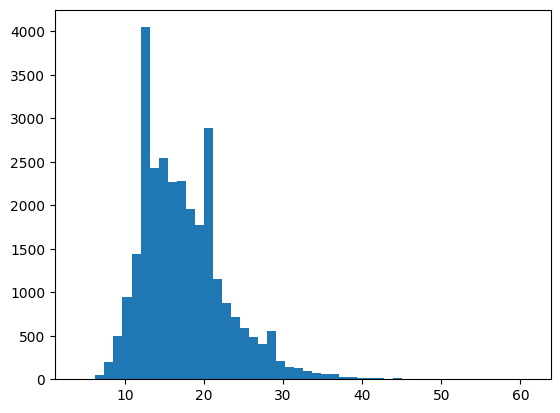

In [ ]:
de_lens = [len(tokenizers[SRC_NAME].encode(text)) for text in tqdm(dataset['train'][SRC_NAME])]
en_lens = [len(tokenizers[TRG_NAME].encode(text)) for text in tqdm(dataset['train'][TRG_NAME])]

plt.hist(de_lens, bins=50)

(array([6.000e+00, 2.400e+01, 1.660e+02, 6.450e+02, 1.467e+03, 2.156e+03,
        0.000e+00, 2.698e+03, 3.127e+03, 3.150e+03, 2.872e+03, 2.636e+03,
        0.000e+00, 2.164e+03, 1.785e+03, 1.434e+03, 1.130e+03, 8.910e+02,
        0.000e+00, 7.170e+02, 4.940e+02, 3.970e+02, 2.600e+02, 2.070e+02,
        0.000e+00, 1.660e+02, 1.140e+02, 8.700e+01, 4.400e+01, 4.600e+01,
        1.800e+01, 0.000e+00, 2.900e+01, 1.500e+01, 1.400e+01, 9.000e+00,
        8.000e+00, 0.000e+00, 3.000e+00, 4.000e+00, 7.000e+00, 5.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 6.  ,  6.84,  7.68,  8.52,  9.36, 10.2 , 11.04, 11.88, 12.72,
        13.56, 14.4 , 15.24, 16.08, 16.92, 17.76, 18.6 , 19.44, 20.28,
        21.12, 21.96, 22.8 , 23.64, 24.48, 25.32, 26.16, 27.  , 27.84,
        28.68, 29.52, 30.36, 31.2 , 32.04, 32.88, 33.72, 34.56, 35.4 ,
        36.24, 37.08, 37.92, 38.76, 39.6 , 40.44, 41.28, 42.12, 42.96,
        43.8 , 44.64,

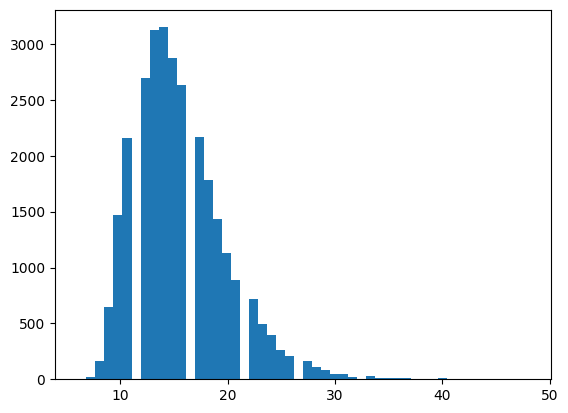

In [ ]:
plt.hist(en_lens, bins=50)

по графикам отмечаем, что практически все тексты содержат не более 30 слов. Для MAX_LENGTH выберем значение 32

## Обучение


In [ ]:
def clean_text(texts):
    """
    Эта функция удаляет все токены (если есть) до [CLS] и после [SEP]
    """
    new_texts = []
    for text in texts:
        cls_pos = text.find('[CLS]')
        text = text[cls_pos + len('[CLS] '):]

        #sep_pos = text.find(' [SEP]')
        sep_pos = text.find('.')
        if sep_pos != -1:
            text = text[:sep_pos]

        new_texts.append(text)

    return new_texts


def tokenize(batch, list_lang=None):
    """
    Токенизируем входную и выходную последовательность.
    Обрезаем все тексты до максимальной длины.
    """
    input = tokenizers[SRC_NAME](
        batch[SRC_NAME],
        padding=True,
        max_length=MAX_LENGTH,
        truncation=True,
        return_tensors='pt'
    ).to(device)
    if list_lang is not None:
      return input

    output = tokenizers[TRG_NAME](
        batch[TRG_NAME],
        padding=True,
        max_length=MAX_LENGTH,
        truncation=True,
        return_tensors='pt'
    ).to(device)

    return input, output


def train(model, dataloader, optimizer, ema_model, scheduler):
    """
    Обучает модель на всем наборе данных.
    """
    model.train()
    # при подсчете ошибки игнорируем токены паддинга
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizers[TRG_NAME].pad_token_id)

    for batch in tqdm(dataloader):
        input, output = tokenize(batch)

        logits = model(
            input['input_ids'],
            output['input_ids'],
            input['attention_mask'],
            output['attention_mask']
        )

        # сдвигаем предсказания так, чтобы для каждого токена предсказывать следующий
        shifted_logits = logits[:, :-1]
        shifted_targets = output['input_ids'][:, 1:]

        # переставляем размерности логитов, так как в CrossEntropyLoss
        # предсказания классов должны быть второй размерностью
        loss = criterion(shifted_logits.permute(0, 2, 1), shifted_targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # шаг для warmup
        scheduler.step()
        #for i, group in enumerate(optimizer.param_groups):
        #    group['lr'] = scheduler.get_lr()
        # обновляем параметры алгоритмом ema
        ema_model.update(model.parameters())
        #ema_model.copy_to(model.parameters())
        # считаем точность в батче, игнорируя токены паддинга
        accuracy = (shifted_logits.argmax(-1) == shifted_targets).float()
        accuracy = accuracy[shifted_targets != tokenizers[TRG_NAME].pad_token_id].mean().item()

    print('train_accuracy=', accuracy)


@torch.inference_mode()
def evaluate(model, dataloader):
    """
    Получаем прогнозы на всем наборе данных.
    """
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizers[TRG_NAME].pad_token_id)

    accuracies = []
    losses = []
    text_predictions = []
    text_references = []
    for batch in tqdm(dataloader):
        input, output = tokenize(batch)
        logits = model(
            input['input_ids'],
            output['input_ids'],
            input['attention_mask'],
            output['attention_mask']
        )

        shifted_logits = logits[:, :-1]
        shifted_targets = output['input_ids'][:, 1:]

        # переставляем размерности логитов, так как в CrossEntropyLoss
        # предсказания классов должны быть второй размерностью
        loss = criterion(shifted_logits.permute(0, 2, 1), shifted_targets)
        losses.append(loss.item())

        tokens = shifted_logits.argmax(-1)
        accuracy = (tokens == shifted_targets).float()
        accuracy = accuracy[shifted_targets != tokenizers[TRG_NAME].pad_token_id].mean().item()
        accuracies.append(accuracy)
        # генерируем перевод и сохраняем для подсчета BLEU
        gen_ids = model.generate(input['input_ids'], input['attention_mask'], output['attention_mask'], tokenizers[TRG_NAME].cls_token_id, tokenizers[TRG_NAME].sep_token_id, tokenizers[TRG_NAME].pad_token_id, MAX_LENGTH)
        text_predictions.extend(clean_text(tokenizers[TRG_NAME].batch_decode(gen_ids)))
        text_references.extend(tokenizers[TRG_NAME].batch_decode(output['input_ids'], skip_special_tokens=True))

    bleu_results = bleu_score.compute(predictions=text_predictions, references=text_references)

    # логируем значения ошибки, точности и BLEU
    print('test_accuracy=', np.mean(accuracies))
    print('bleu_results=', bleu_results['bleu'])



In [ ]:
model = Transformer(encoder_vocab_size=len(tokenizers[SRC_NAME]),
                    decoder_vocab_size=len(tokenizers[TRG_NAME]),
                    hidden_size=128,
                    n_head=8,
                    intermediate_size=512,
                    encoder_max_len=MAX_LENGTH,
                    decoder_max_len=MAX_LENGTH,
                    n_layers=4,
                    drop_prob=0.1
                    ).to(device)


print('Model parameters:', sum(torch.numel(p) for p in model.parameters()))

Model parameters: 13685306


In [ ]:
ema_model = ExponentialMovingAverage(model.parameters(), decay=0.999)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

scheduler = WarmupCosineScheduler(optimizer, warmup_steps=2000, max_training_steps=60000)#, min_lr=1e-6)

In [ ]:
for e in range(30):
    print('epoch =', e)
    train(model, train_loader, optimizer, ema_model, scheduler)
    evaluate(model, test_loader)

epoch = 0


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.2945736348628998


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.26698827371001244
bleu_results= 0.028283051958512932
epoch = 1


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.35185185074806213


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.42087634932249784
bleu_results= 0.10524771537317029
epoch = 2


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.4480000138282776


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.4957523485645652
bleu_results= 0.16086444284403048
epoch = 3


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.4833333492279053


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.5327569600194693
bleu_results= 0.1993138218130229
epoch = 4


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.5454545617103577


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.5593001497909427
bleu_results= 0.2228215301073654
epoch = 5


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.699999988079071


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.5801528133451939
bleu_results= 0.23736538661354112
epoch = 6


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.5517241358757019


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.5961942542344332
bleu_results= 0.26084374605565946
epoch = 7


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.642276406288147


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.6047534719109535
bleu_results= 0.2636131740952663
epoch = 8


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.692307710647583


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.6151294261217117
bleu_results= 0.2761669256844008
epoch = 9


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.6120689511299133


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.6228050999343395
bleu_results= 0.28037309547311623
epoch = 10


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.6371681690216064


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.6303668264299631
bleu_results= 0.28912978579963433
epoch = 11


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.6557376384735107


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.6355572994798422
bleu_results= 0.2845603280940106
epoch = 12


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.5952381491661072


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.6423350162804127
bleu_results= 0.30242500073948736
epoch = 13


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.6972476840019226


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.6498838607221842
bleu_results= 0.3089438903549144
epoch = 14


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.5922330021858215


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.6480845306068659
bleu_results= 0.29509227252286285
epoch = 15


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.6320754885673523


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.6518188286572695
bleu_results= 0.31300181849035696
epoch = 16


  0%|          | 0/907 [00:00<?, ?it/s]

train_accuracy= 0.6285714507102966


  0%|          | 0/32 [00:00<?, ?it/s]

test_accuracy= 0.6552848257124424
bleu_results= 0.3102246064068723
epoch = 17


  0%|          | 0/907 [00:00<?, ?it/s]

In [2]:
torch.save(model.state_dict(), PATH_TO_MODEL)

# Прогноз для тестовой выборки и запись результатов

In [ ]:
# считываем данные для тестовой генерации
data_files = {'grader': PATH_TO_GRADER}
dataset_dr = load_dataset('csv', data_files=data_files)['grader']
grader_loader = DataLoader(dataset_dr, shuffle=False, batch_size=32)


Generating grader split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset_dr

Dataset({
    features: ['de'],
    num_rows: 1014
})

In [ ]:
# прогнозируем
with torch.inference_mode():
    model.eval()
    text_predictions = []
    for batch in tqdm(grader_loader):
        input = tokenize(batch, [SRC_NAME])
        gen_ids = model.generate(input['input_ids'], input['attention_mask'], input['attention_mask'], tokenizers[TRG_NAME].cls_token_id, tokenizers[TRG_NAME].sep_token_id, tokenizers[TRG_NAME].pad_token_id, MAX_LENGTH)
        text_predictions.extend(clean_text(tokenizers[TRG_NAME].batch_decode(gen_ids)))


  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
text_predictions[:10]

['a group of men are performing a truck on a truck',
 'a man sleeping on a couch in a green room',
 'a boy with headphones sits on the shoulders of a woman',
 'two men building a blue ice cream on a lake',
 'a balding man wearing a red life jacket sitting in a small boat',
 'a woman in a red coat holds a " device to a blue purse in a blue tank top, holding a picture',
 'a brown dog runs on the black dog',
 'a little boy with a maroon jersey swings a baseball ball in a field of a baseball field',
 'a man talks on a messy office',
 'a smiling woman with a peach and a peach is holding a mountain']

In [ ]:
# сохраняем результаты перевода в файл
pd.DataFrame(text_predictions, columns=['prediction']).to_csv(PATH_TO_SOLUTION, sep='\t', index=False)


In [ ]:
predictions = pd.read_csv(PATH_TO_SOLUTION, sep="\t")#["prediction"].values
predictions

,prediction
0,a group of men are performing a truck on a truck
1,a man sleeping on a couch in a green room
2,a boy with headphones sits on the shoulders of...
3,two men building a blue ice cream on a lake
4,a balding man wearing a red life jacket sittin...
...,...
1009,a man is cooking a grilling food at a man ' s ...
1010,a group of police officers standing in front o...
1011,an older white - haired woman looks into her g...
1012,two men stand on the phone outside
